# Robinson Crusoe or 10 minutes to respy

This is a short introduction to respy for new users. As economists love Robinsonades [<sup>1</sup>](#fn1), we will showcase the implementation of a Robinson Crusoe economy as a discrete choice dynamic programming model. Throughout the notebook you find italic text which make you familiar with Robinson's story. We will first set the scene with a broad introduction and then turn to the precise model specification. We continue by simulating the model and analyze its comparative statics. We then extend the model and showcase the estimation of the model parameters.  

Just to be clear, don't misinterpret the fact that we explain **respy** using such a simplistic model. **respy** is not a toy and can just as well solve state-of-the-art structural models. It's just easier to explain **respy** in a situation where we don't have to explain a complicated model at the same time. 

In [1]:
%matplotlib inline

import io
import matplotlib.pyplot as plt
import pandas as pd
import respy as rp
import yaml
import seaborn as sns
import numpy as np

from pathlib import Path
from time import time

plt.style.use("../_static/respy.mplstyle")

## Introduction  

---
*After setting sail against his parents' wishes, being captured by pirates, escaping from them, building a plantation, and setting sail again to capture slaves in Africa, [Robinson Crusoe](https://en.wikipedia.org/wiki/Robinson_Crusoe) stranded on a small island. He is alone with one dog, two cats, and only some supplies. He goes fishing to make ends meet and if he is too tired he will relax in his hammock. But, he cannot relax to often as storing food is a difficult task on a tropical island.*

---

In the discrete choice dynamic programming model, Robinson chooses every period $t = 0, \dots, T - 1$ to either go fishing, $a = 0$, or spend the day in the hammock, $a = 1$, to maximize his expected sum of discounted lifetime utility. The utility of a choice, $U(s_t, a_t)$, depends on the state $s_t$, which contains information on the individual's characteristics, and the chosen alternative $a_t$. For working alternatives like fishing utility consists of two components, a wage and a non-pecuniary component.

$$
    U(s_t, a_t) = W(s_t, a_t) + N(s_t, a_t)
$$

For non-working alternatives like the hammock, $W(s_t, a_t) = 0$. The wage is defined as

$$\begin{align}
        W(s_t, a_t)  &= r_a \exp\{x^w_{at} \beta^w_a + \epsilon_{at}\}\\
    \ln(W(s_t, a_t)) &= \ln(r_a) + x^w_{at} \beta^w_a + \epsilon_{at}
\end{align}$$


where $r_a$ is normally a market rental price for the skill units generated in the exponential expression. Another interpretation is that $ln(r_a)$ is simply the constant in the skill units. The skill units are generated by two components. $x^w_{at}$ and $\beta^w_a$ are the choice- and time-dependent covariates and parameters related to the wage signaled by superscript $w$. $\epsilon_{at}$ is a choice-specific random shock from the shock vector $\epsilon_t \sim \mathcal{N}(0, \Sigma)$ for all choices. Shocks are usually correlated across choices in one period, but are independent across periods.

The non-pecuniary rewards for working alternatives are a vector dot product of covariates $x_t^w$ and parameters $\beta^w$. The superscript $w$ signals that the components belong to working alternatives.

$$
    N^w(s_t, a_t) = x_t^w\beta^w
$$

The non-pecuniary reward for non-working alternatives is very similar except that the shocks enter the equation additively. Superscript $n$ stands for non-pecuniary.

$$
    N^n(s_t, a_t) = x_t^n\beta^n + \epsilon_{at}
$$

Along with the lower triangular elements of the shock variance-covariance matrix of $\epsilon_t$, the utility parameters $\beta_a^w$, $\beta_a^n$ and $r_a$ form the main parameters of the model.

If Robinson chooses to go fishing, he gains one additional unit of experience in the next period. Experience starts at zero and goes over 1, 2, 3 up to $T - 1$.

The general assumption imposed on Robinson is that he is forward-looking and maximizes the expected present value of utility over the remaining lifetime. W.l.o.g. $t = 0$ and let $V(s_0)$ define the value of the maximization which is achieved by a sequence of choices, $\{a_t\}^T_{t = 0}$, such that every action is in the choice set, $a_t \in C(s_t)$ and $s_{t + 1}$ adheres to the law of motion. Then, the expected present value of lifetime utility in state $s_0$ is

$$
    V(s_0) = \text{E} \max_{\{a_t\}^T_{t = 0}} \left[
        \sum^T_{t = 0} \delta^t U(s_t, a_t) \, \Big|
        \, a_t \in C(s_t), s_{t+1} = m(s_t, a_t)
    \right]
$$

Note that the shocks in period $t = 0$ are not stochastic. Thus, one can extract the utility in the current period $U(s_0, a_0)$, also called the flow utility, and the discount factor $\delta$ from the expectation. Then, the formula can be rewritten so that the second term becomes the maximum over alternative-specific value functions at time $t = 1$ which are also called continuation values.

$$\begin{align}
    V(s_0) &= \max_{a_0} \, U(s_0, a_0) + \delta \text{E} \max_{\{a_t\}^T_{t = 1}}
              \left[
                  \sum^T_{t = 1} \delta^{t - 1} U(s_t, a_t) \, \Big|
                  \, a_t \in C(s_t), s_{t + 1} = m(s_t, a_t)
              \right] \\
           &= \max_{a_0} \, U(s_0, a_0)
              + \delta \text{E} \max_{a_1} V_{a_1}(s_1)
\end{align}$$

The maximum over alternative-specific value functions can be rewritten as the value function of state $s_1$ or $V(s_1) = \max_{a_1} V_{a_1}(s_1)$ which yields the famous Bellman equation. Due to the recursive nature of the problem, the alternative-specific value functions are defined as

$$\begin{equation}
    V_a(s_t) = \begin{cases}
        U(s_t, a_t) + \delta \text{E} V(s_{t+1}) & \text{if } t < T \\
        U(s_t, a_t) & \text{if } t = T
    \end{cases}
\end{equation}$$

The former equation shows that the shocks in period $t + 1$ are unknown to the individual in period $t$. Thus, utility must be maximized given the joint distribution of shocks in period $t + 1$ which is a maximization problem over a two-dimensional integral. Denote the non-stochastic part of a state as $s^-$. Then, Robinson maximizes

$$\begin{equation}
    V(s_t) = \max_{a_t}\{
        U(s_t, a_t) + \delta \int_{\epsilon_{0, t + 1}} \dots \int_{\epsilon_{2, t + 1}}
        \max_{a_{t + 1}} V_{a_{t + 1}}(s^-_{t + 1}, \epsilon_{t + 1})
        f_\epsilon(\epsilon_{t + 1})
        d_{\epsilon_{0, t + 1}} \dots d_{\epsilon_{2, t + 1}}
    \}
\end{equation}$$

## Specification

How can we express the equations and parameters with **respy**? The following cell contains the code to write a `.csv` file which is the cornerstone of a model as it contains all parameters and some other specifications. With `io.StringIO` we can pretend it is an actual file on the filesystem and easily loaded with `pandas`.

In [2]:
params = """category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_fishing,constant,-1
nonpec_hammock,constant,2.5
nonpec_hammock,not_fishing_last_period,-1
shocks_sdcorr,sd_fishing,1
shocks_sdcorr,sd_hammock,1
shocks_sdcorr,corr_hammock_fishing,-0.2
lagged_choice_1_hammock,constant,1
"""

In [3]:
params = pd.read_csv(io.StringIO(params), index_col=["category", "name"])
params

value
category                name                          
delta                   delta                     0.95
wage_fishing            exp_fishing               0.10
nonpec_fishing          constant                 -1.00
nonpec_hammock          constant                  2.50
                        not_fishing_last_period  -1.00
shocks_sdcorr           sd_fishing                1.00
                        sd_hammock                1.00
                        corr_hammock_fishing     -0.20
lagged_choice_1_hammock constant                  1.00

The DataFrame for the parameters contains a two-level MultiIndex to group parameters in categories. `name` should be uniquely assigned in each category or otherwise only the sum of identically named parameters is identified. `value` contains the value of the parameter. Note that we named Robinson's alternatives `"fishing"` and `"hammock"` and we have to use the names consistently. As long as you stick to lowercase letters separated by underscores, you can choose any name you want.

The parameter specification contains following entries:

- The first entry contains the discount factor of individuals.
- The second category `"wage_fishing"` contains the parameters of the log wage equation for fishing. The group contains only one name called `"exp_fishing"` where `"exp_*"` is an identifier in the model for experience accumulated in a certain alternative. **respy** requires that you respect those identifiers of which there are not many and reference your alternatives consistently with the same name. If you stick to lowercase letters possibly separated by underscores, you are fine.
- The third and fourth categories concern the non-pecuniary reward of fishing and relaxing in the hammock.
- `"shocks_sdcorr"` groups the lower triangular of the variance-covariance matrix of shocks.
- `"lagged_choice_1_hammock"` governs the distribution of previous choices at the begin of the model horizon.

`params` is complemented with `options` which contains additional information. Here is short description:

- `"n_periods"` defines the number of periods for which decision rules are computed.
- `"_seed"`: Seeds are used in every model component to ensure reproducibility. You can use any seed you would like or even repeat the same seed number. Internally, we ensure that randomness is completely uncorrelated.
- `"estimation_draws"` defines the number of draws used to simulate the choice probabilities with Monte Carlo simulation in the maximum likelihood estimation.
- `"estimation_tau"` controls the temperature of the softmax function to avoid zero-valued choice probabilities.
- `"interpolation_points"` controls how many states are used to approximate the value functions of others states in each period. `-1` turns the approximation off. The approximation is detailed in Keane and Wolpin (1994).
- ``"simulation_agents"`` defines how many individuals are simulated.
- ``"solution_draws"`` defines the number of draws used to simulate the expected value functions in the solution.
- `"covariates"` is another dictionary where the key determines the covariate's name and the value is its definition. Here, we have to define what `"constant"` means.

In [4]:
options = """n_periods: 10
estimation_draws: 200
estimation_seed: 500
estimation_tau: 0.001
interpolation_points: -1
simulation_agents: 1_000
simulation_seed: 132
solution_draws: 500
solution_seed: 456
covariates:
    constant: "1"
    not_fishing_last_period: "lagged_choice_1 != 'fishing'"
"""

In [5]:
options = yaml.safe_load(options)
options

{'n_periods': 10,
 'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"}}

## Simulation

We are now ready to simulate the model.

In [6]:
simulate = rp.get_simulate_func(params, options)
df = simulate(params)

In [7]:
df.head(15)

Experience_Fishing Lagged_Choice_1  Shock_Reward_Fishing  \
Identifier Period                                                             
0          0                        0         hammock             -0.035035   
           1                        1         fishing              0.074254   
           2                        1         hammock             -0.354560   
           3                        1         hammock             -0.109397   
           4                        2         fishing             -1.063705   
           5                        2         hammock             -0.106235   
           6                        3         fishing             -0.692603   
           7                        3         hammock             -0.555217   
           8                        3         hammock             -0.943424   
           9                        3         hammock             -1.541738   
1          0                        0         hammock             -0.713137   
           1                        0         hammock             -0.464134   
           2                        0         hammock              0.066755   
           3                        1         fishing             -0.748565   
           4                        1         hammock             -0.130574   

                   Meas_Error_Wage_Fishing  Shock_Reward_Hammock  \
Identifier Period                                                  
0          0                             1              0.040965   
           1                             1              1.506491   
           2                             1              1.185316   
           3                             1             -0.785877   
           4                             1              1.245234   
           5                             1             -1.854834   
           6                             1             -1.238533   
           7                             1             -0.542048   
           8                             1             -0.581919   
           9                             1              0.487632   
1          0                             1              1.418950   
           1                             1             -0.384774   
           2                             1             -0.844060   
           3                             1             -1.348821   
           4                             1             -0.539693   

                   Meas_Error_Wage_Hammock  Dense_Key  Core_Index   Choice  \
Identifier Period                                                            
0          0                             1          0           1  fishing   
           1                             1          1           0  hammock   
           2                             1          2           0  hammock   
           3                             1          3           1  fishing   
           4                             1          4           6  hammock   
           5                             1          5           1  fishing   
           6                             1          6          10  hammock   
           7                             1          7          13  hammock   
           8                             1          8           1  hammock   
           9                             1          9           3  hammock   
1          0                             1          0           1  hammock   
           1                             1          1           3  hammock   
           2                             1          2           1  fishing   
           3                             1          3           5  hammock   
           4                             1          4           9  fishing   

                       Wage  ...  Nonpecuniary_Reward_Fishing  Wage_Fishing  \
Identifier Period            ...                                              
0          0       0.965571  ... 

We can inspect Robinson's decisions period by period.

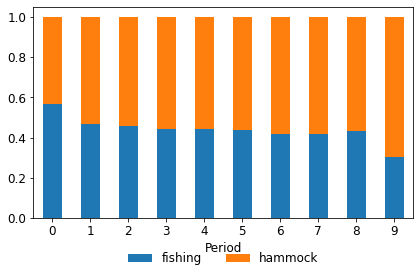

In [8]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=2)

plt.show()
plt.close()

We can also analyze the persistence in decisions.

<AxesSubplot:xlabel='Choice', ylabel='Lagged_Choice_1'>

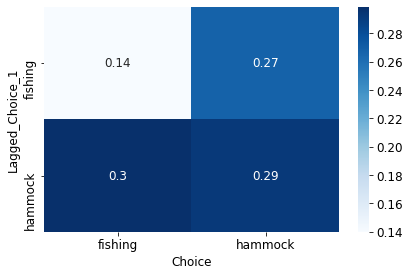

In [9]:
data = pd.crosstab(df.Lagged_Choice_1, df.Choice, normalize=True)
sns.heatmap(data, cmap="Blues", annot=True)

## Analysis

We now study how Robinson's behavior changes as we increase the returns to experience. We do so by plotting the average level of final experience in the sample under the different parameterizations.

This analysis of the comparative statics of the model is straightforward to implement. In models of educational choice, this type of analysis is often applied to evaluate the effect of alternative tuition policies on average educational attainment. See Keane & Wolpin (1997, 2001) for example. The basic structure of the analysis remains the same.

In [10]:
# Specification of grid for evaluation
num_points = 15    
grid_start = 0.0
grid_stop = 0.3

grid_points = np.linspace(grid_start, grid_stop, num_points)

rslts = list()
for value in grid_points:
    
    params.loc["wage_fishing", "exp_fishing"] = value

    df = simulate(params)

    stat = df.groupby("Identifier")["Experience_Fishing"].max().mean()
    rslts.append(stat)

We collected all results in `rslts` and are ready to create a basic visualization.

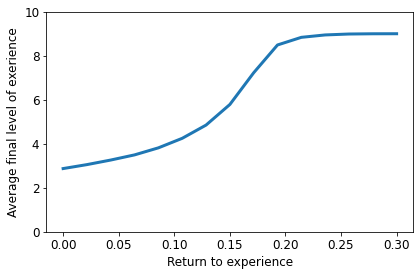

In [11]:
fig, ax = plt.subplots()

ax.plot(grid_points, rslts)

ax.set_ylim([0, 10])
ax.set_xlabel("Return to experience")
ax.set_ylabel("Average final level of exerience")

plt.show()
plt.close()

In the absence of any returns to experience, Robinson still spends more than two periods fishing. This share then increases with the return. Starting at around 0.2, Robinson spends all his time fishing.

## Extension

Let us make the model more interesting!

---
*At some point Crusoe notices that a group of cannibals occasionally visits the island and celebrate one of their dark rituals. But then, a prisoner can escape and becomes Crusoe's new friend Friday whom he teaches English. In return Friday can share his knowledge once to help Robinson improve his fishing skills, but that is only possible after Robinson tried at least once to go fishing.*

---

A common extension to structural models is to increase the choice set. Here, we want to add another choice called `"friday"` which affects the utility of fishing. The choice should be available once, starting with the third period, and only after Robinson has been fishing before.

Note that, we load the example models with the function, `rp.get_example_model`. The command for the former model is `params, options, df = rp.get_example_model("robinson_crusoe_basic")`. You can use `with_data=False` to suppress the automatic simulation of a sample with this parameterization.

In [12]:
params, options = rp.get_example_model("robinson_crusoe_extended", with_data=False)

At first, take a look at the parameterization. There is a new positive parameter called `"contemplation_with_friday"` which enters the wage equation of fishing. The choice `"friday"` itself has a negative constant utility term which models the effort costs of learning and the food penalty. The variance-covariance matrix is also adjusted.

In [13]:
params

value
category                name                            
delta                   delta                       0.95
wage_fishing            exp_fishing                 0.10
                        contemplation_with_friday   0.40
nonpec_fishing          constant                   -1.00
nonpec_friday           constant                   -1.00
                        not_fishing_last_period    -1.00
nonpec_hammock          constant                    2.50
                        not_fishing_last_period    -1.00
shocks_sdcorr           sd_fishing                  1.00
                        sd_friday                   1.00
                        sd_hammock                  1.00
                        corr_friday_fishing         0.00
                        corr_hammock_fishing        0.00
                        corr_hammock_friday         0.00
lagged_choice_1_hammock constant                    1.00

Turning to the `options`, we can see that the new covariate `"contemplation_with_friday"` is only affecting utility if Robinson is experienced in fishing and only for one interaction with friday. This naturally limits the interaction with Friday. The key `"negative_choice_set"` can be used to restrict the choice Friday to the third and following periods. The first key matches a choice. The value of the key can be a list of strings. If the string evaluates to `True`, a utility penalty ensures that individuals will never choose the corresponding states. There exist some states in the state space which will never be reached because choices are mutually exclusive or are affected by other restrictions. Filters under `"core_state_space_filters"` can be used to purge those states from the state space, reducing runtime and memory consumption.

In [14]:
options

{'n_periods': 10,
 'estimation_draws': 200,
 'estimation_seed': 500,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 500,
 'solution_seed': 456,
 'covariates': {'constant': '1',
  'contemplation_with_friday': 'exp_friday == 1 and exp_fishing >= 1',
  'not_fishing_last_period': "lagged_choice_1 != 'fishing'"},
 'negative_choice_set': {'friday': ['period < 2', 'exp_fishing == 0']},
 'core_state_space_filters': ["period > 0 and exp_fishing + exp_friday == period and lagged_choice_1 == 'hammock'",
  'period <= 2 and exp_friday != 0',
  'period >= 3 and period - exp_friday < 2',
  'exp_friday > 0 and exp_fishing == 0',
  "exp_friday > 0 and exp_fishing == 1 and lagged_choice_1 == 'fishing'",
  "period - exp_friday == 2 and lagged_choice_1 != 'friday' and period > 2",
  "exp_{choices_w_exp} == 0 and lagged_choice_1 == '{choices_w_exp}'"]}

Now, let us simulate a sample of the new model.

In [15]:
simulate = rp.get_simulate_func(params, options)

In [16]:
df = simulate(params)

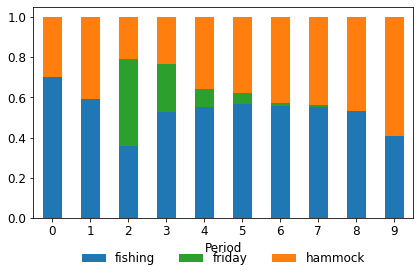

In [17]:
fig, ax = plt.subplots()

df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(
    stacked=True, ax=ax, color=["C0", "C2", "C1"],
)

plt.xticks(rotation="horizontal")

plt.legend(loc="lower center", bbox_to_anchor=(0.5,-0.275), ncol=3)

plt.show()
plt.close()

## Estimation

For model calibration, **respy** supports estimation via maximum likelihood and the method of simulated moments. An appropriate criterion function function for both methods can be constructed in just a few steps.

For optimization of the criterion, the use of external optimization libraries is requried. We recommend [estimagic](https://github.com/OpenSourceEconomics/estimagic), an open-source tool to estimate structural models and more. **estimagic** can be used for the optimization and standard error calculation of a criterion function produced by **respy**. 

Unlike other optimization libraries, ``estimagic`` does not optimize over a simple vector of parameters, but instead stores parameters in a ``pd.DataFrame``, which makes it easier to parse them into the quantities we need, store lower and upper bounds together with parameters and express constraints on the parameters. 

For ``estimagic``, we need to pass constraints on the parameters in a list containing dictionaries. Each dictionary is a constraint. A constraint includes two components: First, we need to tell ``estimagic`` which parameters we want to constrain. This is achieved by specifying an index location which will be passed to `df.loc`. Then, define the type of the constraint. Here, we only impose the constraint that the shock parameters have to be valid variances and correlations.

*Note*: It is possible to utilize other optimization libraries but we recommend **estimagic** due to the reasons stated above.

In [18]:
from estimagic import maximize

In [19]:
crit_func = rp.get_log_like_func(params, options, df)
crit_func(params)

constr = rp.get_parameter_constraints("robinson_crusoe")

In [23]:
results = maximize(
    criterion=crit_func, 
    params=params, 
    algorithm="scipy_lbfgsb", 
    algo_options={"stopping_max_criterion_evaluations": 3}, 
    constraints=constr,
)

Running the minimal working example shown above will start an optimization that is limited to three criterion evaluations (for the sake of this tutorial). **estimagic** will also produce a logging database called `logging.db` that stores information about the optimization. The package offers many useful options to set up a tractable estimation for your model.

More information can be found in the **estimagic** documentation: https://estimagic.readthedocs.io/.

## Footnotes

<span id="fn1"><sup>1</sup>
    One of the earliest references of Robinsonades in economics can be found in Marx (1867). In the 37th footnote, he mentions that even Ricardo used the theme before him.
</span>

## References

> Bellman, R. (1957). Dynamic Programming. *Princeton University Press*, Princeton, NJ.

> Keane, M. P. and Wolpin, K. I. (1997). [The Career Decisions of Young Men](https://doi.org/10.1086/262080). *Journal of Political Economy*, 105(3): 473-522.

> Marx, K. (1867). Das Kapital, Bd. 1. *MEW*, Bd, 23, 405